In [93]:
import os
import pandas as pd
import statistics
import numpy as np
import seaborn as sns
import json
import nltk
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
import math
from textblob.sentiments import NaiveBayesAnalyzer
from youtube_transcript_api import YouTubeTranscriptApi as yttra

import settings
import db_functions
import youtube_handler as youtube
import video_analysis_helpers as video_helpers
import sql_field

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
#Get users input to search
keywords = input("Give the cartoon name you want to search:")
keywords = keywords.lower()

#Get videos based on user's input
retrieved_videos = youtube.get_youtube_videos(keywords)
retrieved_videos

Give the cartoon name you want to search:mickey mouse
Videos count: 78


,id,title,url
0,xHxBG7bZa9s,English cartoon with subtitles for kids,https://www.youtube.com/watch?v=xHxBG7bZa9s
1,EorJ8cEzsZo,A Mickey Mouse Cartoon : Season 2 Episodes 1-1...,https://www.youtube.com/watch?v=EorJ8cEzsZo
2,dvVvm6nGxTI,Bow-Toons Adventures for 30 Minutes! | Compila...,https://www.youtube.com/watch?v=dvVvm6nGxTI
4,VBKgPmS5Fyw,A Mickey Mouse Cartoon : Season 1 Episodes 1-1...,https://www.youtube.com/watch?v=VBKgPmS5Fyw
5,j-d8p1Pclgc,Mickey Mouse Clubhouse Full Episodes 🌈 Mickey ...,https://www.youtube.com/watch?v=j-d8p1Pclgc
...,...,...,...
93,3hCOof8uk2Q,Mickey&#39;s House Of Villains 2001 - Lovely M...,https://www.youtube.com/watch?v=3hCOof8uk2Q
96,AWQ2v-Wv0-o,Mickey Mouse Nursery Rhymes | Cartoon Rhymes F...,https://www.youtube.com/watch?v=AWQ2v-Wv0-o
97,mHhGBv1GSvE,Peppa Pig Official Channel | Peppa Pig Visits ...,https://www.youtube.com/watch?v=mHhGBv1GSvE
98,sdHNjMc9FQo,Amore Motore | A Mickey Mouse Cartoon | Disney...,https://www.youtube.com/watch?v=sdHNjMc9FQo


In [46]:
videos = video_helpers.filter_by_keywords(keywords, retrieved_videos)
print(f"count after input keywords filters:{videos.shape}")
videos.head()

count after input keywords filters:(68, 3)


,id,title,url
1,EorJ8cEzsZo,a mickey mouse cartoon : season 2 episodes 1-1...,https://www.youtube.com/watch?v=EorJ8cEzsZo
4,VBKgPmS5Fyw,a mickey mouse cartoon : season 1 episodes 1-1...,https://www.youtube.com/watch?v=VBKgPmS5Fyw
5,j-d8p1Pclgc,mickey mouse clubhouse full episodes 🌈 mickey ...,https://www.youtube.com/watch?v=j-d8p1Pclgc
6,KTJQdbvCMag,gone to pieces | a mickey mouse cartoon | disn...,https://www.youtube.com/watch?v=KTJQdbvCMag
8,XeRYuMEM_4k,no | a mickey mouse cartoon | disney shorts,https://www.youtube.com/watch?v=XeRYuMEM_4k


In [47]:
# retrieve video duration & url

videos = youtube.get_videos_duration(videos.id)
videos.drop(videos.columns.difference(['id', 'title','duration','url']), 1, inplace=True)
print(f"Videos count: {videos.shape[0]}")
videos.head()

Videos count: 48


,id,title,duration,url
0,EorJ8cEzsZo,a mickey mouse cartoon : season 2 episodes 1-1...,PT35M54S,https://www.youtube.com/watch?v=EorJ8cEzsZo
1,VBKgPmS5Fyw,a mickey mouse cartoon : season 1 episodes 1-1...,PT36M24S,https://www.youtube.com/watch?v=VBKgPmS5Fyw
2,j-d8p1Pclgc,mickey mouse clubhouse full episodes 🌈 mickey ...,PT26M32S,https://www.youtube.com/watch?v=j-d8p1Pclgc
3,KTJQdbvCMag,gone to pieces | a mickey mouse cartoon | disn...,PT3M47S,https://www.youtube.com/watch?v=KTJQdbvCMag
4,XeRYuMEM_4k,no | a mickey mouse cartoon | disney shorts,PT3M46S,https://www.youtube.com/watch?v=XeRYuMEM_4k


In [48]:
# filter by duration & excluded words

duration_filter_videos = video_helpers.filter_by_duration(videos)
exclude_filter_videos = video_helpers.filter_by_excluded_words(videos)

videos = videos[(exclude_filter_videos)&(duration_filter_videos)]
print(f"count after exclus and duration filters:{videos.shape}")
videos.head()

7069.416666666667
count after exclus and duration filters:(40, 4)


,id,title,duration,url
3,KTJQdbvCMag,gone to pieces | a mickey mouse cartoon | disn...,227,https://www.youtube.com/watch?v=KTJQdbvCMag
4,XeRYuMEM_4k,no | a mickey mouse cartoon | disney shorts,226,https://www.youtube.com/watch?v=XeRYuMEM_4k
6,AN3Lu8EveHY,two can’t play | a mickey mouse cartoon | disn...,226,https://www.youtube.com/watch?v=AN3Lu8EveHY
7,iNT8T58G3f4,wonders of the deep | a mickey mouse cartoon |...,436,https://www.youtube.com/watch?v=iNT8T58G3f4
8,znMnAdzlVMY,movie time | a mickey mouse cartoon | disney s...,231,https://www.youtube.com/watch?v=znMnAdzlVMY


In [50]:
# get subtitles as json

subs_json = yttra.get_transcripts(videos.id, continue_after_error=True)

In [51]:
# analyze subtitles

subs_df = video_helpers.analyze_subs(subs_json)
print(f"Subs count: {subs_df.shape[0]}")
subs_df.head()

Subs count: 30


,id,duration_good,duration_bad,subs
0,KTJQdbvCMag,85.180,55.520,"Gentlemen, find your favorite chair, because I..."
1,XeRYuMEM_4k,171.879,63.118,"Gentlemen, find your favorite chair, because I..."
2,AN3Lu8EveHY,84.180,62.180,"Gentlemen, find your favorite chair, because I..."
3,iNT8T58G3f4,485.484,0.000,"Gentlemen, find your favorite chair, because I..."
4,znMnAdzlVMY,94.813,92.714,"Gentlemen, find your favorite chair, because I..."


In [52]:
videos = videos.merge(subs_df, how='inner', on='id')
print(f"Videos count: {videos.shape[0]}")
videos.dropna(inplace=True)
videos.head()

Videos count: 30


,id,title,duration,url,duration_good,duration_bad,subs
0,KTJQdbvCMag,gone to pieces | a mickey mouse cartoon | disn...,227,https://www.youtube.com/watch?v=KTJQdbvCMag,85.180,55.520,"Gentlemen, find your favorite chair, because I..."
1,XeRYuMEM_4k,no | a mickey mouse cartoon | disney shorts,226,https://www.youtube.com/watch?v=XeRYuMEM_4k,171.879,63.118,"Gentlemen, find your favorite chair, because I..."
2,AN3Lu8EveHY,two can’t play | a mickey mouse cartoon | disn...,226,https://www.youtube.com/watch?v=AN3Lu8EveHY,84.180,62.180,"Gentlemen, find your favorite chair, because I..."
3,iNT8T58G3f4,wonders of the deep | a mickey mouse cartoon |...,436,https://www.youtube.com/watch?v=iNT8T58G3f4,485.484,0.000,"Gentlemen, find your favorite chair, because I..."
4,znMnAdzlVMY,movie time | a mickey mouse cartoon | disney s...,231,https://www.youtube.com/watch?v=znMnAdzlVMY,94.813,92.714,"Gentlemen, find your favorite chair, because I..."


In [53]:
# calculate the percentage about quality of subs

videos['percentage_of_good_subs'] = videos['duration_good'] / (videos['duration_good'] + videos['duration_bad'])
videos.head()

,id,title,duration,url,duration_good,duration_bad,subs,percentage_of_good_subs
0,KTJQdbvCMag,gone to pieces | a mickey mouse cartoon | disn...,227,https://www.youtube.com/watch?v=KTJQdbvCMag,85.180,55.520,"Gentlemen, find your favorite chair, because I...",0.605402
1,XeRYuMEM_4k,no | a mickey mouse cartoon | disney shorts,226,https://www.youtube.com/watch?v=XeRYuMEM_4k,171.879,63.118,"Gentlemen, find your favorite chair, because I...",0.731409
2,AN3Lu8EveHY,two can’t play | a mickey mouse cartoon | disn...,226,https://www.youtube.com/watch?v=AN3Lu8EveHY,84.180,62.180,"Gentlemen, find your favorite chair, because I...",0.575157
3,iNT8T58G3f4,wonders of the deep | a mickey mouse cartoon |...,436,https://www.youtube.com/watch?v=iNT8T58G3f4,485.484,0.000,"Gentlemen, find your favorite chair, because I...",1.000000
4,znMnAdzlVMY,movie time | a mickey mouse cartoon | disney s...,231,https://www.youtube.com/watch?v=znMnAdzlVMY,94.813,92.714,"Gentlemen, find your favorite chair, because I...",0.505597


In [54]:
# calculate the threshold about percentage of quality of subs

avg_of_percentage = videos.percentage_of_good_subs.mean()

percentage_threhold = videos['percentage_of_good_subs']  > avg_of_percentage

videos  = videos[percentage_threhold]
videos.head()

,id,title,duration,url,duration_good,duration_bad,subs,percentage_of_good_subs
0,KTJQdbvCMag,gone to pieces | a mickey mouse cartoon | disn...,227,https://www.youtube.com/watch?v=KTJQdbvCMag,85.180,55.520,"Gentlemen, find your favorite chair, because I...",0.605402
1,XeRYuMEM_4k,no | a mickey mouse cartoon | disney shorts,226,https://www.youtube.com/watch?v=XeRYuMEM_4k,171.879,63.118,"Gentlemen, find your favorite chair, because I...",0.731409
3,iNT8T58G3f4,wonders of the deep | a mickey mouse cartoon |...,436,https://www.youtube.com/watch?v=iNT8T58G3f4,485.484,0.000,"Gentlemen, find your favorite chair, because I...",1.000000
5,G-pqP_9r55E,new shoes | a mickey mouse cartoon | disney sh...,436,https://www.youtube.com/watch?v=G-pqP_9r55E,228.720,99.160,"Gentlemen, find your favorite chair, because I...",0.697572
6,Rq1xaWi6fA0,mickey mouse shorts - no,217,https://www.youtube.com/watch?v=Rq1xaWi6fA0,99.868,0.000,"Gentlemen, find your favorite chair, because I...",1.000000


In [55]:
# Pattern Analyzer polarity & subjectivity

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

videos['polarity(PatternAnalyzer)'] = videos['subs'].apply(pol)
videos['subjectivity(PatternAnalyzer)'] = videos['subs'].apply(sub)

videos['polarity(PatternAnalyzer)'] = (videos['polarity(PatternAnalyzer)'] - (-1)) / (1-(-1))

videos = videos.reset_index(drop=True)
print(videos.shape[0])
videos.head()

16


,id,title,duration,url,duration_good,duration_bad,subs,percentage_of_good_subs,polarity(PatternAnalyzer),subjectivity(PatternAnalyzer)
0,KTJQdbvCMag,gone to pieces | a mickey mouse cartoon | disn...,227,https://www.youtube.com/watch?v=KTJQdbvCMag,85.180,55.520,"Gentlemen, find your favorite chair, because I...",0.605402,0.645858,0.632407
1,XeRYuMEM_4k,no | a mickey mouse cartoon | disney shorts,226,https://www.youtube.com/watch?v=XeRYuMEM_4k,171.879,63.118,"Gentlemen, find your favorite chair, because I...",0.731409,0.648472,0.575952
2,iNT8T58G3f4,wonders of the deep | a mickey mouse cartoon |...,436,https://www.youtube.com/watch?v=iNT8T58G3f4,485.484,0.000,"Gentlemen, find your favorite chair, because I...",1.000000,0.633384,0.523721
3,G-pqP_9r55E,new shoes | a mickey mouse cartoon | disney sh...,436,https://www.youtube.com/watch?v=G-pqP_9r55E,228.720,99.160,"Gentlemen, find your favorite chair, because I...",0.697572,0.639402,0.569966
4,Rq1xaWi6fA0,mickey mouse shorts - no,217,https://www.youtube.com/watch?v=Rq1xaWi6fA0,99.868,0.000,"Gentlemen, find your favorite chair, because I...",1.000000,0.640122,0.568556


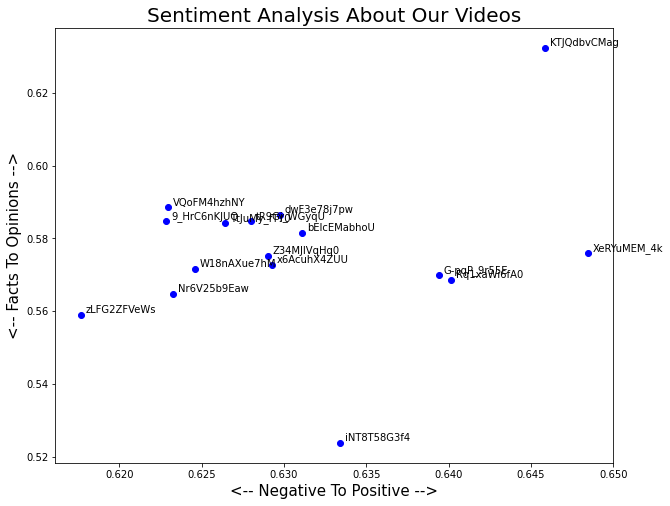

In [56]:
# plot about polarity & subjectivity Pattern Analyzer

plt.rcParams['figure.figsize'] = [10, 8]

for index, row in videos.iterrows():
    x = row['polarity(PatternAnalyzer)']
    y = row['subjectivity(PatternAnalyzer)']
    plt.scatter(x, y, color='blue')
    plt.text(x+0.0003, y+0.0006, row['id'], fontsize=10)
    
plt.title('Sentiment Analysis About Our Videos', fontsize=20)
plt.xlabel('<-- Negative To Positive -->', fontsize=15)
plt.ylabel('<-- Facts To Opinions -->', fontsize=15)

plt.show()

In [57]:
# create a list to hold all the 10 pieces of text

list_pieces = video_helpers.get_subs_pieces(videos)

In [58]:
# calculate the polarity of 10 pieces of every video

polarity_sub_PatternAnalyzer = []
for lp in list_pieces:
    polarity_piece = []
    for p in lp:
        polarity = (TextBlob(p).sentiment.polarity - (-1))/(1 - (-1))
        polarity_piece.append(polarity)
    polarity_sub_PatternAnalyzer.append(polarity_piece)
    
polarity_sub_PatternAnalyzer

pol_PA_pieces = pd.DataFrame(polarity_sub_PatternAnalyzer)
pol_PA_pieces.head()

,0,1,2,3,4,5,6,7,8,9
0,0.750000,0.525000,0.725625,0.666667,0.515767,0.500000,0.630208,0.623535,0.746875,0.481250
1,0.781250,0.654687,0.631250,0.760417,0.603125,0.648125,0.570833,0.766667,0.552778,0.650000
2,0.693229,0.601811,0.667014,0.647917,0.725556,0.548096,0.559722,0.700000,0.586484,0.576984
3,0.652273,0.634725,0.653516,0.597115,0.620666,0.549833,0.631735,0.710972,0.607340,0.674107
4,0.652482,0.642904,0.661788,0.610156,0.597062,0.528694,0.714896,0.721190,0.594328,0.654167


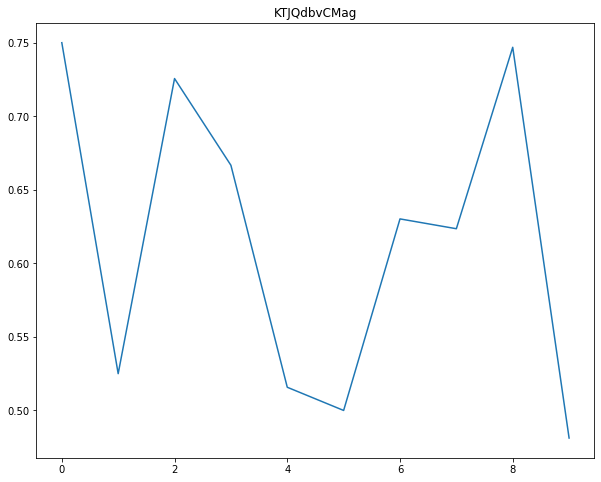

In [59]:
# Show the plot for one video

plt.plot(polarity_sub_PatternAnalyzer[0])
plt.title(videos.loc[0,'id'])
plt.show()

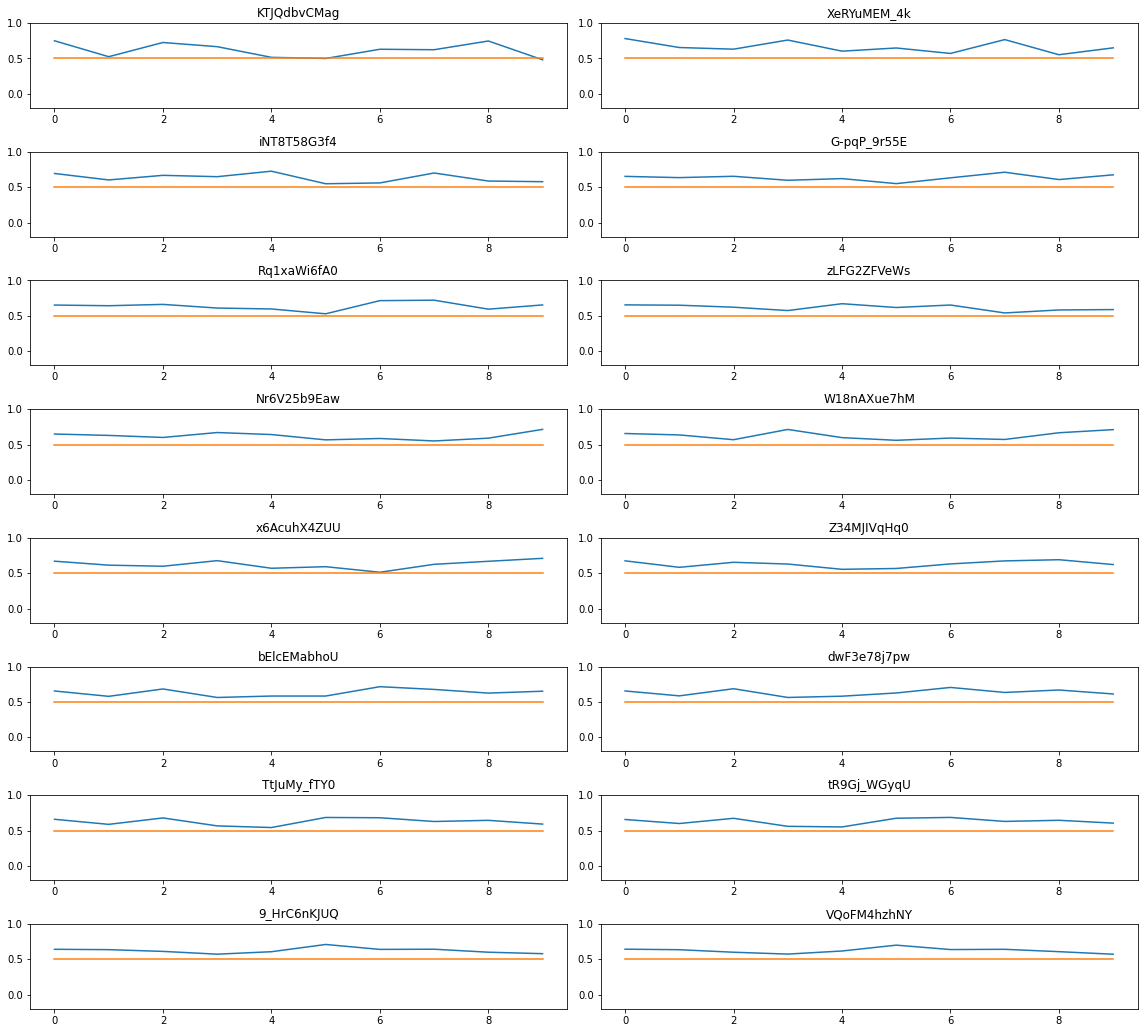

In [60]:
# Show the plot for all videos (PatternAnalyzer)

plt.rcParams['figure.figsize'] = [16, 16]

for index, vid in videos.iterrows():    
    plt.subplot((videos.shape[0]//2)+1, 2, index+1)
    plt.plot(polarity_sub_PatternAnalyzer[index])
    plt.plot(np.arange(0,10), np.full((10,1), 0.5))
    plt.title(vid['id'])
    plt.ylim(ymin=-0.2, ymax=1)
    plt.tight_layout()
    
plt.show()

In [121]:
# calculate the polarity (Naive Bayes Analyzer) 

pol = lambda x: TextBlob(x, analyzer=NaiveBayesAnalyzer()).sentiment.p_pos

videos['polarity(NaiveBayes)'] = videos['subs'].apply(pol)
videos

,id,title,duration,url,duration_good,duration_bad,subs,percentage_of_good_subs,polarity(PatternAnalyzer),subjectivity(PatternAnalyzer),polarity(NaiveBayes),polarity_mean
0,KTJQdbvCMag,gone to pieces | a mickey mouse cartoon | disn...,227,https://www.youtube.com/watch?v=KTJQdbvCMag,85.180,55.520,"Gentlemen, find your favorite chair, because I...",0.605402,0.645858,0.632407,0.503490,0.574674
1,XeRYuMEM_4k,no | a mickey mouse cartoon | disney shorts,226,https://www.youtube.com/watch?v=XeRYuMEM_4k,171.879,63.118,"Gentlemen, find your favorite chair, because I...",0.731409,0.648472,0.575952,0.008089,0.328280
2,iNT8T58G3f4,wonders of the deep | a mickey mouse cartoon |...,436,https://www.youtube.com/watch?v=iNT8T58G3f4,485.484,0.000,"Gentlemen, find your favorite chair, because I...",1.000000,0.633384,0.523721,0.000281,0.316833
3,G-pqP_9r55E,new shoes | a mickey mouse cartoon | disney sh...,436,https://www.youtube.com/watch?v=G-pqP_9r55E,228.720,99.160,"Gentlemen, find your favorite chair, because I...",0.697572,0.639402,0.569966,1.000000,0.819701
4,Rq1xaWi6fA0,mickey mouse shorts - no,217,https://www.youtube.com/watch?v=Rq1xaWi6fA0,99.868,0.000,"Gentlemen, find your favorite chair, because I...",1.000000,0.640122,0.568556,1.000000,0.820061
5,zLFG2ZFVeWs,mickey mouse clubhouse - episode 97 | official...,268,https://www.youtube.com/watch?v=zLFG2ZFVeWs,409.981,26.450,"Gentlemen, find your favorite chair, because I...",0.939395,0.617669,0.558880,1.000000,0.808835
6,Nr6V25b9Eaw,mickey mouse works s01e01 english,1370,https://www.youtube.com/watch?v=Nr6V25b9Eaw,870.527,480.476,"Gentlemen, find your favorite chair, because I...",0.644356,0.623241,0.564708,1.000000,0.811621
7,W18nAXue7hM,carried away | a mickey mouse cartoon | disney...,227,https://www.youtube.com/watch?v=W18nAXue7hM,147.670,39.260,"Gentlemen, find your favorite chair, because I...",0.789975,0.624597,0.571566,1.000000,0.812299
8,x6AcuhX4ZUU,over the moon | a mickey mouse cartoon | disne...,226,https://www.youtube.com/watch?v=x6AcuhX4ZUU,113.350,54.020,"Gentlemen, find your favorite chair, because I...",0.677242,0.629259,0.572586,1.000000,0.814629
9,Z34MJIVqHq0,rainbow fun 🌈 | mickey mouse clubhouse | disne...,291,https://www.youtube.com/watch?v=Z34MJIVqHq0,276.987,63.753,"Gentlemen, find your favorite chair, because I...",0.812898,0.629014,0.575237,1.000000,0.814507


In [62]:
# Calculate the polarity of Naive Bayes for each 10 pieces of text

polarity_sub_NaiveBayes = []
for lp in list_pieces:
    polarity_piece_NaiveBayes = []
    for p in lp:
        polarity_piece_NaiveBayes.append(TextBlob(p, analyzer=NaiveBayesAnalyzer()).sentiment.p_pos)
    polarity_sub_NaiveBayes.append(polarity_piece_NaiveBayes)

In [63]:
# convert to DataFrame

pol_NB_pieces = pd.DataFrame(polarity_sub_NaiveBayes)
pol_NB_pieces.head()

,0,1,2,3,4,5,6,7,8,9
0,0.617299,0.698483,0.291193,0.583847,0.219435,0.715853,0.461545,0.637885,0.364185,0.769960
1,0.554197,0.577736,0.659345,0.510145,0.544069,0.421877,0.555355,0.029962,0.041680,0.547420
2,0.631072,0.584327,0.070195,0.816344,0.029269,0.339202,0.354749,0.029940,0.044614,0.924282
3,0.396976,0.009062,0.180915,0.804626,0.010768,0.986108,0.698408,0.996562,0.913088,0.999828
4,0.466425,0.009761,0.299028,0.672948,0.016418,0.941563,0.834254,0.915275,0.999958,0.727624


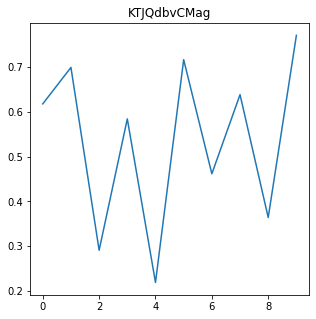

In [65]:
# Show the plot for one video (Naive Bayes)

plt.rcParams['figure.figsize'] = [5, 5]
plt.plot(polarity_sub_NaiveBayes[0])
plt.title(videos.loc[0, 'id'])
plt.show()

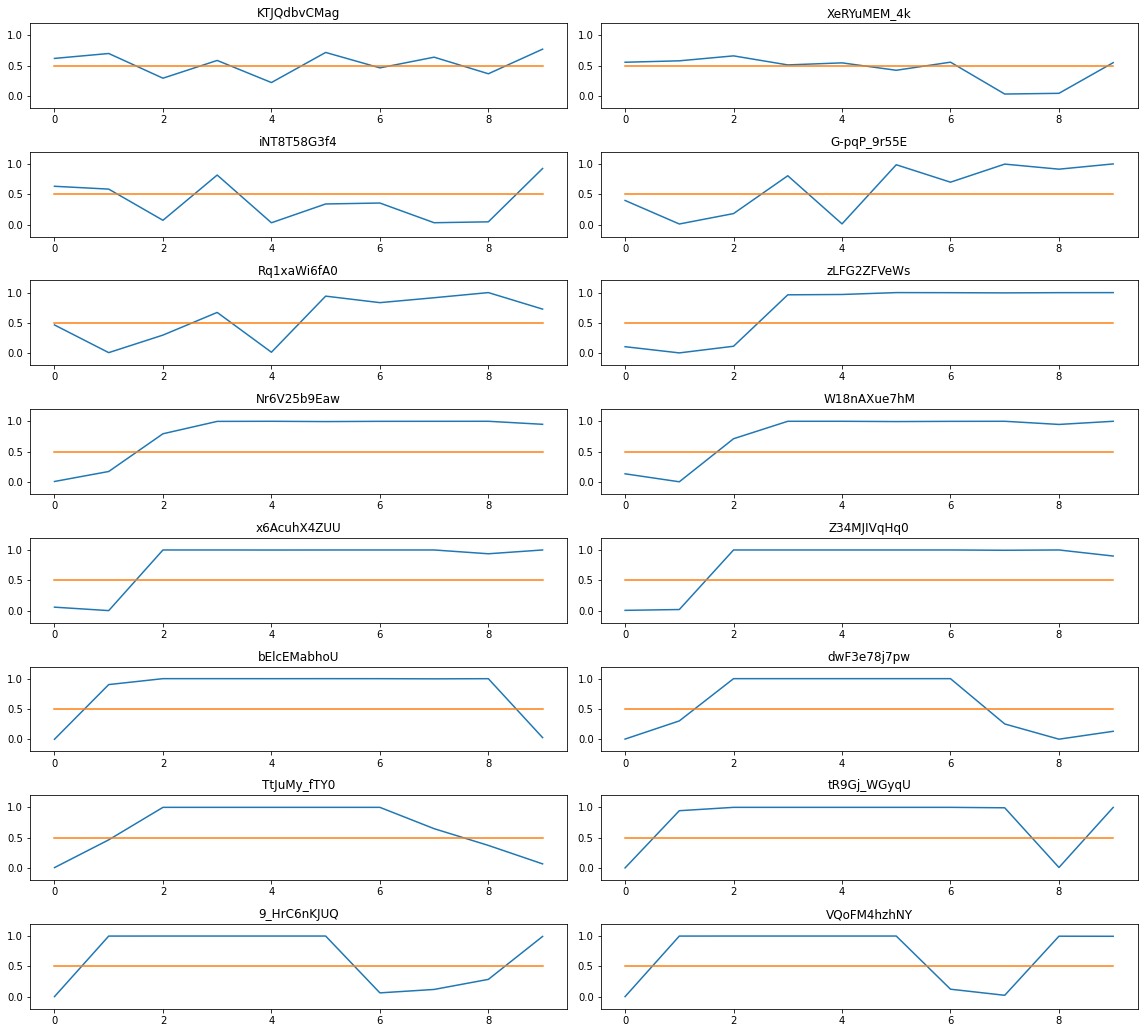

In [66]:
# Show the plot for all videos Naive Bayes

plt.rcParams['figure.figsize'] = [16, 16]

for index, vid in videos.iterrows():    
    plt.subplot((videos.shape[0]//2)+1, 2, index+1)
    plt.plot(polarity_sub_NaiveBayes[index])
    plt.plot(np.arange(0,10), np.full((10,1), 0.5))
    plt.title(vid['id'])
    plt.ylim(ymin=-0.2, ymax=1.2)
    plt.tight_layout()
    
plt.show()

In [122]:
# calculate the polarity mean od 2 analyzers

videos['polarity_mean'] = (videos['polarity(PatternAnalyzer)'] + videos['polarity(NaiveBayes)']) / 2
videos.head()

,id,title,duration,url,duration_good,duration_bad,subs,percentage_of_good_subs,polarity(PatternAnalyzer),subjectivity(PatternAnalyzer),polarity(NaiveBayes),polarity_mean
0,KTJQdbvCMag,gone to pieces | a mickey mouse cartoon | disn...,227,https://www.youtube.com/watch?v=KTJQdbvCMag,85.180,55.520,"Gentlemen, find your favorite chair, because I...",0.605402,0.645858,0.632407,0.503490,0.574674
1,XeRYuMEM_4k,no | a mickey mouse cartoon | disney shorts,226,https://www.youtube.com/watch?v=XeRYuMEM_4k,171.879,63.118,"Gentlemen, find your favorite chair, because I...",0.731409,0.648472,0.575952,0.008089,0.328280
2,iNT8T58G3f4,wonders of the deep | a mickey mouse cartoon |...,436,https://www.youtube.com/watch?v=iNT8T58G3f4,485.484,0.000,"Gentlemen, find your favorite chair, because I...",1.000000,0.633384,0.523721,0.000281,0.316833
3,G-pqP_9r55E,new shoes | a mickey mouse cartoon | disney sh...,436,https://www.youtube.com/watch?v=G-pqP_9r55E,228.720,99.160,"Gentlemen, find your favorite chair, because I...",0.697572,0.639402,0.569966,1.000000,0.819701
4,Rq1xaWi6fA0,mickey mouse shorts - no,217,https://www.youtube.com/watch?v=Rq1xaWi6fA0,99.868,0.000,"Gentlemen, find your favorite chair, because I...",1.000000,0.640122,0.568556,1.000000,0.820061


In [68]:
# concatenate them (PatternAnalyzer and NaiveBayes) - 10 pieces

result = pd.concat([pol_PA_pieces, pol_NB_pieces], axis=1, join="inner")
result.head()

means = pd.DataFrame()

for i in range(result.shape[1]//2):
    means[str(i)] = (result.iloc[:,i] + result.iloc[:,i+10])/2

means

,0,1,2,3,4,5,6,7,8,9
0,0.683650,0.611742,0.508409,0.625257,0.367601,0.607926,0.545877,0.630710,0.555530,0.625605
1,0.667724,0.616212,0.645297,0.635281,0.573597,0.535001,0.563094,0.398314,0.297229,0.598710
2,0.662151,0.593069,0.368604,0.732130,0.377412,0.443649,0.457236,0.364970,0.315549,0.750633
3,0.524624,0.321894,0.417215,0.700871,0.315717,0.767970,0.665071,0.853767,0.760214,0.836968
4,0.559453,0.326332,0.480408,0.641552,0.306740,0.735128,0.774575,0.818233,0.797143,0.690895
5,0.381307,0.327783,0.368704,0.769065,0.820175,0.808884,0.825655,0.768082,0.790961,0.794116
6,0.327818,0.400395,0.696972,0.833882,0.820504,0.780538,0.792277,0.774970,0.795000,0.832177
7,0.394743,0.318855,0.640296,0.856561,0.798863,0.777492,0.795070,0.785775,0.807156,0.855248
8,0.363409,0.306979,0.799268,0.838769,0.784598,0.795965,0.756755,0.812880,0.802990,0.855158
9,0.339550,0.300580,0.827175,0.814873,0.777471,0.783349,0.815737,0.834658,0.845463,0.761259


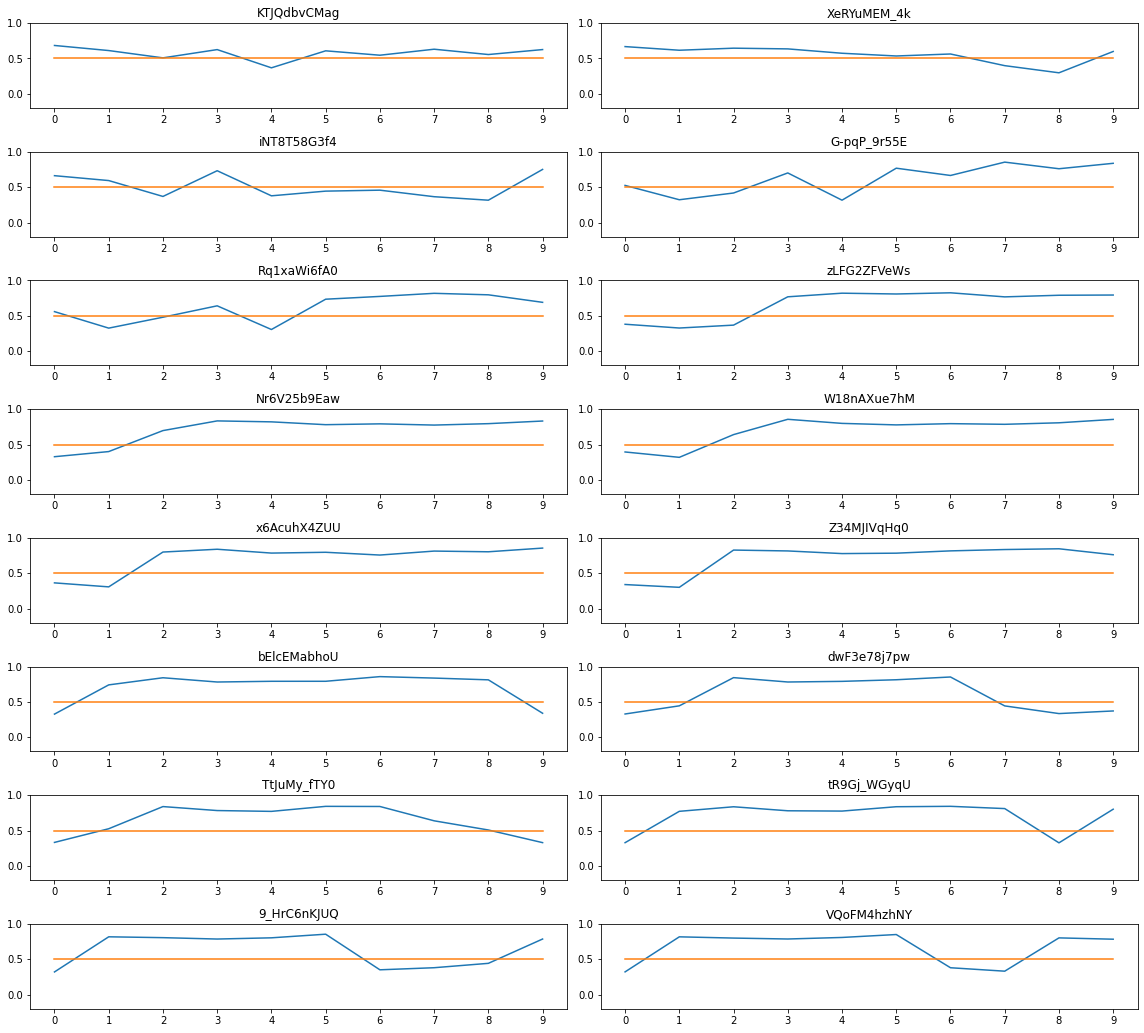

In [69]:
# Show the plot for all videos (polarity mean - ci)

plt.rcParams['figure.figsize'] = [16, 16]

for index, vid in videos.iterrows():    
    plt.subplot((videos.shape[0]//2)+1, 2, index+1)
    plt.plot(means.iloc[index,:])
    plt.plot(np.arange(0,10), np.full((10,1), 0.5))
    plt.title(vid['id'])
    plt.ylim(ymin=-0.2, ymax=1)
    plt.tight_layout()
    
plt.show()

In [117]:
# create db and tables (youtube_videos, youtube_videos_details)

dbf = db_functions.MyFunctions(keywords.replace(" ",""))

# create db
# if exist drop it
dbf.create_db()

# write db_name to config file
db_conf={"db_name": keywords.replace(" ","")}
with open("dbconfig.json", "w") as outfile:
    json.dump(db_conf, outfile)

table_name = 'youtube_videos'
id = sql_field.Field('id', 'varchar(20) primary key not null')
title = sql_field.Field('title', 'varchar(1000)')
url = sql_field.Field('url', 'varchar(100)')
duration = sql_field.Field('duration', 'float')
duration_good = sql_field.Field('duration_good', 'float')
duration_bad = sql_field.Field('duration_bad', 'float')
subs = sql_field.Field('subs', 'text')
percentage_of_good_subs = sql_field.Field('percentage_of_good_subs', 'float')
polarityPA = sql_field.Field('polarityPA', 'float')
subjectivityPA = sql_field.Field('subjectivityPA', 'float')
polarityNB = sql_field.Field('polarityNB', 'float')
polarity_mean = sql_field.Field('polarity_mean', 'float')

# create the table youtube_videos
dbf.create_table(table_name, id, title, url, duration, duration_good, duration_bad, subs, percentage_of_good_subs, polarityPA, subjectivityPA, polarityNB, polarity_mean)

table_name = 'youtube_video_stats' 
timestamp = sql_field.Field('timestamp', 'datetime')
views = sql_field.Field('views', 'int')
likes = sql_field.Field('likes', 'int')
dislikes = sql_field.Field('dislikes', 'int')

# create table youtube_video_stats
dbf.create_table(table_name, id, timestamp, views, likes, dislikes)


In [124]:
videos

,id,title,duration,url,duration_good,duration_bad,subs,percentage_of_good_subs,polarity(PatternAnalyzer),subjectivity(PatternAnalyzer),polarity(NaiveBayes),polarity_mean
0,KTJQdbvCMag,gone to pieces | a mickey mouse cartoon | disn...,227,https://www.youtube.com/watch?v=KTJQdbvCMag,85.180,55.520,"Gentlemen, find your favorite chair, because I...",0.605402,0.645858,0.632407,0.503490,0.574674
1,XeRYuMEM_4k,no | a mickey mouse cartoon | disney shorts,226,https://www.youtube.com/watch?v=XeRYuMEM_4k,171.879,63.118,"Gentlemen, find your favorite chair, because I...",0.731409,0.648472,0.575952,0.008089,0.328280
2,iNT8T58G3f4,wonders of the deep | a mickey mouse cartoon |...,436,https://www.youtube.com/watch?v=iNT8T58G3f4,485.484,0.000,"Gentlemen, find your favorite chair, because I...",1.000000,0.633384,0.523721,0.000281,0.316833
3,G-pqP_9r55E,new shoes | a mickey mouse cartoon | disney sh...,436,https://www.youtube.com/watch?v=G-pqP_9r55E,228.720,99.160,"Gentlemen, find your favorite chair, because I...",0.697572,0.639402,0.569966,1.000000,0.819701
4,Rq1xaWi6fA0,mickey mouse shorts - no,217,https://www.youtube.com/watch?v=Rq1xaWi6fA0,99.868,0.000,"Gentlemen, find your favorite chair, because I...",1.000000,0.640122,0.568556,1.000000,0.820061
5,zLFG2ZFVeWs,mickey mouse clubhouse - episode 97 | official...,268,https://www.youtube.com/watch?v=zLFG2ZFVeWs,409.981,26.450,"Gentlemen, find your favorite chair, because I...",0.939395,0.617669,0.558880,1.000000,0.808835
6,Nr6V25b9Eaw,mickey mouse works s01e01 english,1370,https://www.youtube.com/watch?v=Nr6V25b9Eaw,870.527,480.476,"Gentlemen, find your favorite chair, because I...",0.644356,0.623241,0.564708,1.000000,0.811621
7,W18nAXue7hM,carried away | a mickey mouse cartoon | disney...,227,https://www.youtube.com/watch?v=W18nAXue7hM,147.670,39.260,"Gentlemen, find your favorite chair, because I...",0.789975,0.624597,0.571566,1.000000,0.812299
8,x6AcuhX4ZUU,over the moon | a mickey mouse cartoon | disne...,226,https://www.youtube.com/watch?v=x6AcuhX4ZUU,113.350,54.020,"Gentlemen, find your favorite chair, because I...",0.677242,0.629259,0.572586,1.000000,0.814629
9,Z34MJIVqHq0,rainbow fun 🌈 | mickey mouse clubhouse | disne...,291,https://www.youtube.com/watch?v=Z34MJIVqHq0,276.987,63.753,"Gentlemen, find your favorite chair, because I...",0.812898,0.629014,0.575237,1.000000,0.814507


In [119]:
# insert videos into table

dbf.insert_youtube_videos(videos)

INSERT INTO youtube_videos (id,title,url,duration,duration_good,duration_bad,percentage_of_good_subs,polarityPA,subjectivityPA,polarityNB,polarity_mean) VALUES ("KTJQdbvCMag","gone to pieces | a mickey mouse cartoon | disney shorts","https://www.youtube.com/watch?v=KTJQdbvCMag",227,85.17999999999999,55.52, 0.6054015636105188, 0.6458583502121913, 0.6324074074074075 ,0.5034900330551492, 0.5746741916336702);
INSERT INTO youtube_videos (id,title,url,duration,duration_good,duration_bad,percentage_of_good_subs,polarityPA,subjectivityPA,polarityNB,polarity_mean) VALUES ("XeRYuMEM_4k","no | a mickey mouse cartoon | disney shorts","https://www.youtube.com/watch?v=XeRYuMEM_4k",226,171.87899999999996,63.118, 0.7314093371404741, 0.6484716796875, 0.575952380952381 ,0.00808929943525379, 0.3282804895613769);
INSERT INTO youtube_videos (id,title,url,duration,duration_good,duration_bad,percentage_of_good_subs,polarityPA,subjectivityPA,polarityNB,polarity_mean) VALUES ("iNT8T58G3f4","wonders of the deep

16

### Ανάκτηση δεδομένων για το 48ωρο


In [120]:
# retrieve hourly stats for each video for 48 hours and insert them into the youtube_video_stats table

rows_inserted = dbf.get_hourly_stats(num_times=48, interval=3600)
print(f"Rows inserted: {rows_inserted}")